## Efficient-ish Monte Carlo ray tracing for BH+disk light bending rendering

Theory, base code from https://galileo-unbound.blog/2019/07/29/orbiting-photons-around-a-black-hole/

In [1]:
# for 5000 rays
# 50 s (integration of ray paths) + 200 s (ray tracing to disk) = 4.2 min, 10 times faster than previous version

In [2]:
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.spatial.transform import Rotation as R
from scipy.interpolate import griddata
%matplotlib inline

In [205]:
def create_circle(r): # circle shape for representing BH
    circle = plt.Circle((0,0), radius= r, color = 'black')
    return circle
 
def show_shape(patch): # shows circle shape
    ax=plt.gca()
    ax.add_patch(patch)

def refindex(x,y): # set refraction index that bends ray
     
    A = 10 # size of BH <----------------- should be global
    eps = 1e-6
     
    rp0 = np.sqrt(x**2 + y**2);
         
    n = 1/(1 - A/(rp0+eps))
    fac = np.abs((1-9*(A/rp0)**2/8))   # approx correction to Eikonal
    nx = -fac*n**2*A*x/(rp0+eps)**3
    ny = -fac*n**2*A*y/(rp0+eps)**3
      
    return [n,nx,ny]
 
def flow_deriv(x_y_z,tspan): # diff equations to solve, yp[2,3] are vx,vy
    x, y, z, w = x_y_z
     
    [n,nx,ny] = refindex(x,y)
         
    yp = np.zeros(shape=(4,))
    yp[0] = z/n
    yp[1] = w/n
    yp[2] = nx
    yp[3] = ny
     
    return yp

def rot_inter_secdisk(ang,inc,npt):
    angl=ang*np.pi/180
    incl=inc*np.pi/180
    tmin=rin/(1+(np.tan(incl))**2*(1+(np.tan(angl))**2))**(1/2)
    tmax=rout/(1+(np.tan(incl))**2*(1+(np.tan(angl))**2))**(1/2)
    tpp=np.linspace(tmin,tmax,npt)
    tpm=np.linspace(-tmax,-tmin,npt)
    tp=np.hstack((tpm,tpp))
    xp=tp
    yp=-tp*np.tan(incl)
    zp=tp*np.tan(incl)*np.tan(angl)
    diskp=np.vstack((xp,yp,zp))
    dprot=np.array(np.matmul(Rx(ang),diskp)) # the norm is rotation invariant
    return dprot

def Rx(theta):
    # rotation matrix for ray rotation around yz plane
    theta=theta*np.pi/180
    return np.matrix([[ 1, 0           , 0           ],
                   [ 0, np.cos(theta),-np.sin(theta)],
                   [ 0, np.sin(theta), np.cos(theta)]])



# make uniformly random disk, rotates it
def make_disk(rin,rout,nop,inc):
    stoc=4/np.pi # square to circle
    xs=np.random.random(int(nop*stoc))*2*rout-rout
    ys=np.random.random(int(nop*stoc))*2*rout-rout
    filter=(xs**2+ys**2 <= rout**2)&(xs**2+ys**2 >= rin**2)
    totpt=filter.sum() # actual number of points (due to MC)
    xs=xs[filter]
    ys=ys[filter]
    zs=np.zeros(filter.sum())
    dave=np.sqrt(np.pi*rout**2/nop) # average distance between disk points
    dave 
    # rotates disk
    rd = R.from_euler('y', inc, degrees=True) # rotate wrt y axis
    disk=np.vstack((xs,ys,zs))
    rotdisk=np.array([rd.apply(disk[:,i]) for i in range(len(disk[0]))])
    return rotdisk, dave

9996


Text(0,0.5,'zr')

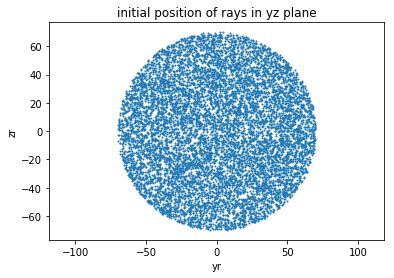

In [236]:
# create initial ray locations
nor=10000 # number of rays
stoc=4/np.pi # square to circle
rmxr=70 # max distance to x
yr=np.random.random(int(nor*stoc))*2*rmxr-rmxr
zr=np.random.random(int(nor*stoc))*2*rmxr-rmxr
filter=(yr**2+zr**2 <= rmxr**2)
print(filter.sum()) # of actual rays (may be different to original due to MC)
yr=yr[filter]
zr=zr[filter]
plt.scatter(yr,zr,s=1)
plt.axis('equal')
plt.title('initial position of rays in yz plane')
plt.xlabel('yr')
plt.ylabel('zr')

In [237]:
# cylindrical coord locations
rray=np.sqrt(yr**2+zr**2)
thray=np.arctan2(zr,yr)*180/np.pi # in deg

In [238]:
%%time 
# integrate rays in 2D (xy plane), 5000 rays take 50 s
xstart = -100
nint = 2000
mxxy = 300 # max x or y, avoids extreme numbers produced by odeint
maxt = 400 # this is total ray path integration time, approx. similar to mxxy - fine tune?
A = 10 # size of black hole <---- should connect to refindex --> make global?
rays=[]
hbh=[] # hits bh?
for ystart in rray: # rays are initially set in 2d (xy plane) and are later rotated
    [n,nx,ny] = refindex(xstart,ystart) 
    y0 = [xstart, ystart, n, 0]
    tspan = np.linspace(1,maxt,nint)
    y = integrate.odeint(flow_deriv, y0, tspan)
    xx = y[1:nint,0]
    yy = y[1:nint,1]
    filt2=(np.abs(xx)<mxxy)&(np.abs(yy)<mxxy)
    xx = xx[filt2]
    yy = yy[filt2]
    zz = np.zeros(filt2.sum())
    # cuts off if ray hits the bh
    filt=np.sqrt(xx**2+yy**2)<10
    if np.any(filt):
        cutoff=np.arange(len(filt))[filt][0]
        xx=xx[:cutoff]
        yy=yy[:cutoff]
        zz=zz[:cutoff]
        hbh+=[1]
    else:
        hbh+=[0]
    rays+=[np.vstack((xx,yy,zz))]


/Users/germanchaparro/miniconda2/envs/py36/lib/python3.5/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


CPU times: user 1min 44s, sys: 1.06 s, total: 1min 45s
Wall time: 1min 47s


Text(0,0.5,'y')

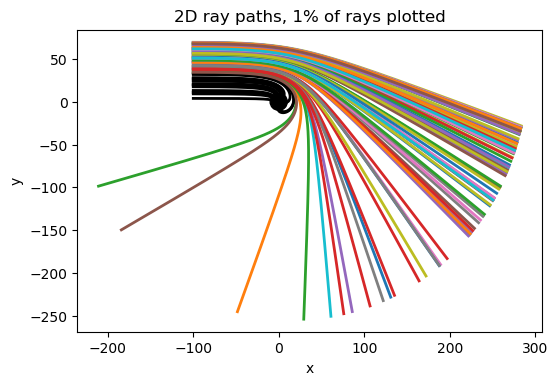

In [241]:
sample = 100 # plot 1 in #sample# rays
plt.figure(dpi=100)
for ray,h in zip(rays[::sample],hbh[::sample]):
    if h == 0:
        lines=plt.plot(ray[0],ray[1])
        plt.setp(lines, linewidth=2)
    else:
        lines=plt.plot(ray[0],ray[1])
        plt.setp(lines, linewidth=2, color = 'black')
plt.axis('equal')
c = create_circle(A)
show_shape(c)
plt.title('2D ray paths, '+str(100*sample//len(rays))+'% of rays plotted')
plt.xlabel('x')
plt.ylabel('y')

In [242]:
# parameters for an inclined disk
rout = 50 # disk outer r
rin = 15 # disk inner r (close to last photon orbit, fine tune?)
inc=20 # inclination
npt=100 # number of points in intersected line (disk n ray plane), see below
dave=(rout-rin)/(npt/2) # average distance between points, more stringent than disk-wide dave (function make_disk) 

 - A disk lying on the xz plane rotated at an inclination $i$ has a normal vector $(\sin i,\cos i,0)$.
     - Therefore the equation of this plane is $x\sin+y\cos i=0$.
 - A ray going along a plane rotated at an angle $\theta$ (variable `thray`) has a normal vector $(0,\sin\theta,\cos\theta)$.
     - Therefore the equation of this plane is $y\sin\theta+z\cos\theta=0$
 - The intersection of these two planes yield a line whose parametric representation is:
 $$
 x=t\\
 y=-t \tan i\\
 z= t\tan i\tan\theta\\
 $$
 - With the $r_\mathrm{in}$ and $r_\mathrm{out}$ constraints, the parameter $t$ varies within:
 $$
 t_\mathrm{min}^2=\frac{r_\mathrm{in}^2}{1+\tan^2i(1+\tan^2\theta)}\\
 t_\text{max}^2=\frac{r_\text{out}^2}{1+\tan^2i(1+\tan^2\theta)}
 $$
 - The intersection of the disk and the ray plane is given by the $t$ range, which creates two 3D line segments (one from $-t_\mathrm{max}$ to $-t_\mathrm{min}$ and another from $t_\mathrm{min}$ to $t_\mathrm{max}$.
 - The procedure is to get these 3D line segments to intersect with the ray plane. It is simpler to rotate the few points in these line segments back to the original xy ray plane and look for a ray-"disk" hit there ("disk" meaning the *now* 2D line segments). Thus, the rays do not need to be rotated (which is kind of computationally expensive) and the search for a hit does not need to occur in 3D (which is *really* computationally expensive).

In [243]:
%%time
# checks if ray hits disk, records radial distance of ray hit from bh center
# if ray does not hit the disk, a -999 value is set
hit=[]
for ray,ang in zip(rays,thray):
    dprot=rot_inter_secdisk(90-ang,inc,npt) # creates 2D line segments (see above)
    # also angle is corrected by 90 deg because reasons (complementary angle? idk)
    check=False
    for point in ray.T[:,0:2]:
        dist=(np.linalg.norm(point-dprot[0:2].T,axis=1).min())
        if dist<dave:
            check=True
            hit+=[np.linalg.norm(point)]
            break
    if check==False: 
        hit+=[-999] # 0.2 s for 5 rays, 3 min for 5000 rays

CPU times: user 6min 15s, sys: 3.44 s, total: 6min 18s
Wall time: 6min 34s


In [244]:
# array with initial ray positions in yz plane and radial distance of ray hit from BH center
proy=np.vstack((yr,zr,np.array(hit))).T

Text(0.5,1,'All rays (9996) vs. rays that hit the disk (2845)')

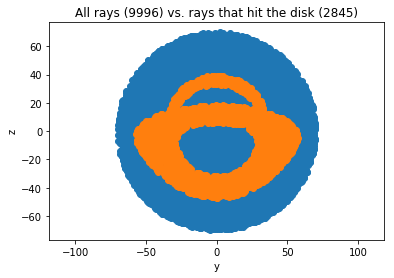

In [245]:
y=proy[:,0]
z=proy[:,1]
plt.scatter(y,z)
plt.scatter(y[proy[:,2]>0],z[proy[:,2]>0])
plt.axis('equal')
plt.xlabel('y')
plt.ylabel('z')
plt.title('All rays ('+str(len(rays))+') vs. rays that hit the disk ('+str((proy[:,2]>0).sum())+')')

/Users/germanchaparro/miniconda2/envs/py36/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


Text(0.5,1,'Rays that hit the disk, no interpolation')

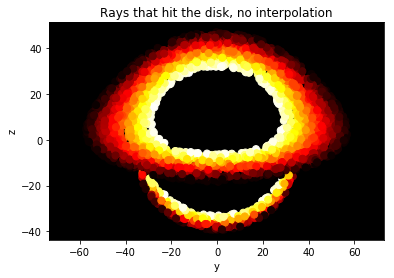

In [246]:
# flipped plot because it looks cooler
y=proy[:,0][proy[:,2]>0]
z=proy[:,1][proy[:,2]>0]
cl=proy[:,2][proy[:,2]>0]
plt.scatter(-y,-z,c=cl,cmap=cm.hot_r,s=50) # color is set to be more intense farther from the bh
plt.axis('equal')
ax=plt.axes()
ax.set_facecolor('k')
plt.xlabel('y')
plt.ylabel('z')
plt.title('Rays that hit the disk, no interpolation')

In [258]:
# make arrays for interpolation
N=500
y=proy[:,0]
z=proy[:,1]

yi = np.linspace(y.min(),y.max(),N)
zi = np.linspace(z.min(),z.max(),N)
Y, Z = np.meshgrid(yi, zi)
P = np.array([Y.flatten(), Z.flatten() ]).transpose()

/Users/germanchaparro/miniconda2/envs/py36/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


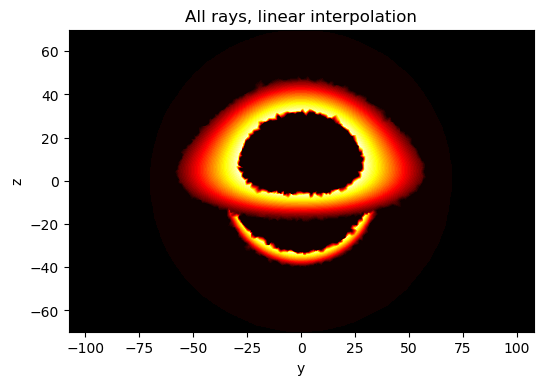

In [259]:
# make and plot interpolation

c=np.copy(proy[:,2])
#filtbh=(proy[:,2]<0)&(np.array(hbh)==1) # this is to check whether ray hits bh or misses everythin
c[c<0]=55 # tuned to make the plot look nice

Vi=(c)
Pi=proy[:,:2]

V_cubic = griddata(-Pi, Vi, P, method = "linear").reshape([N, N])
plt.figure(dpi=100)
plt.contourf(Y, Z, V_cubic, 50, cmap = cm.hot_r)
#plt.colorbar()
ax=plt.axes()
ax.set_facecolor('k')
plt.axis('equal')
plt.xlim(-100,100)
plt.xlabel('y')
plt.ylabel('z')
plt.title('All rays, linear interpolation')
plt.show()

/Users/germanchaparro/miniconda2/envs/py36/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


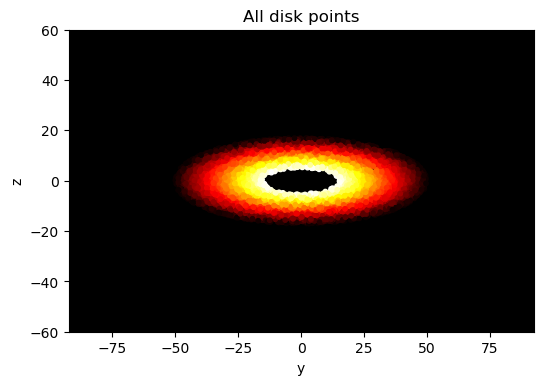

In [261]:
# not literally the same disk point distribution, but Monte Carlo is forgiving
nop = 5e3 # number of init points
rotdisk,dave = make_disk(rin,rout,nop,inc)
xd=rotdisk[:,0]
yd=rotdisk[:,1]
zd=rotdisk[:,2]
color=np.sqrt(xd**2+yd**2+zd**2)
plt.figure(dpi=100)
plt.scatter(yd,zd,s=10,c=color,cmap = cm.hot_r)
plt.axis('equal')
plt.xlabel('y')
plt.ylabel('z')
plt.title('All disk points')
#plt.colorbar()

ax=plt.axes()
ax.set_facecolor('k')
#circ = create_circle(10)
#show_shape(circ)
plt.xlim(-100,100)
plt.ylim(-60,60)
plt.show()